## Import

In [1]:
#pip install optuna

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

#model preprocessing
from sklearn.preprocessing import OneHotEncoder

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.model_selection import cross_val_score #for optuna

#optuna
import optuna

In [3]:
data = pd.read_csv("bike-sharing_hourly.csv")

### Understand the Data

In [4]:
data.head(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [6]:
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
col_to_drop = ['instant', 'dteday']

data.drop(columns=col_to_drop, inplace=True)

## EDA

<Axes: xlabel='hr'>

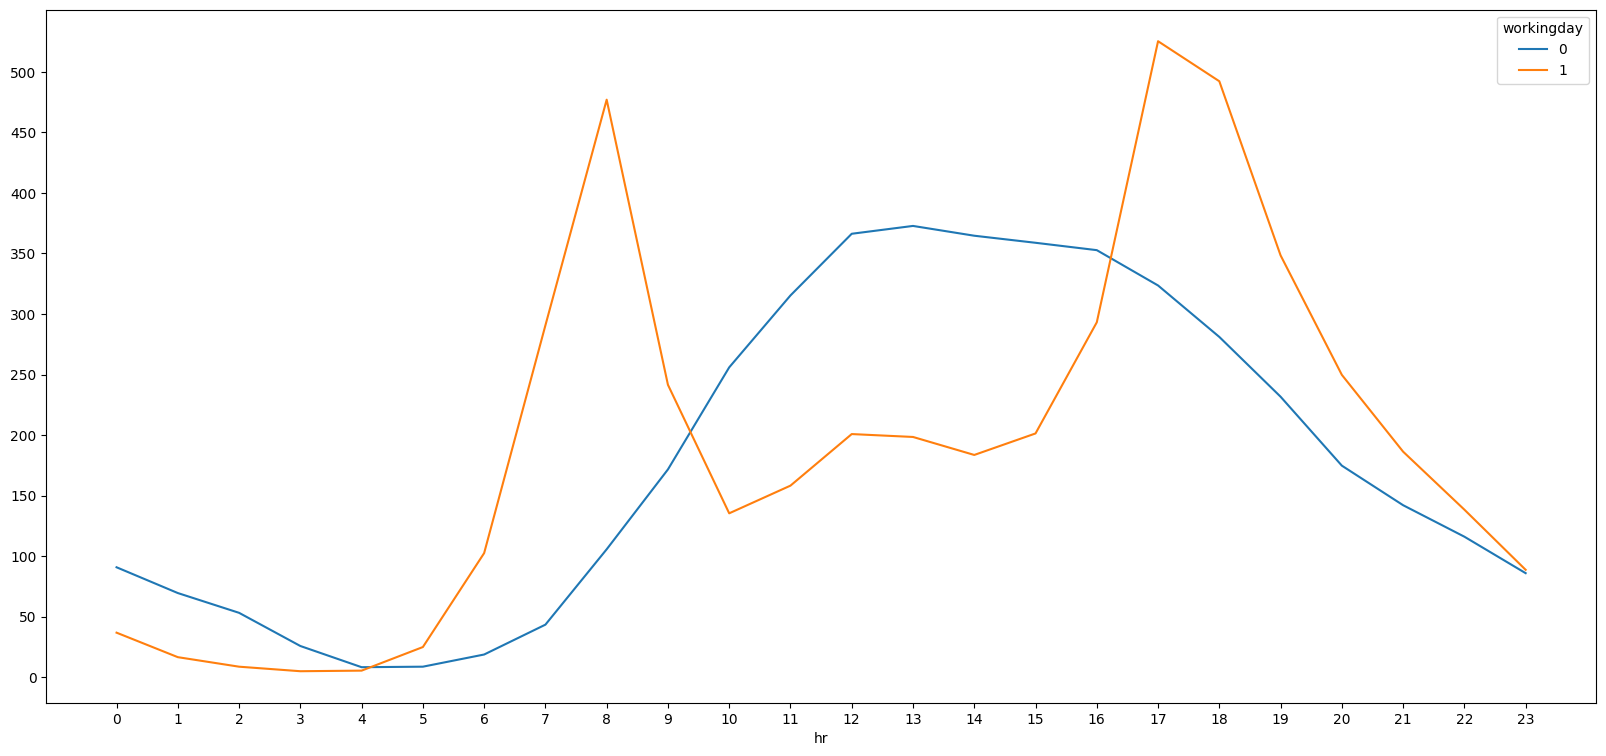

In [8]:
data[data.cnt.notnull()].groupby(["hr", "workingday"]).cnt.mean().unstack().plot(figsize=(20,9), xticks=range(0,24), yticks=range(0,550,50))

- The orange line shows the number of bikes being rented out on working day (presumably also a weekday).
- The blue line shows the number of bikes being rented out on non-working days (presumably the weekend).

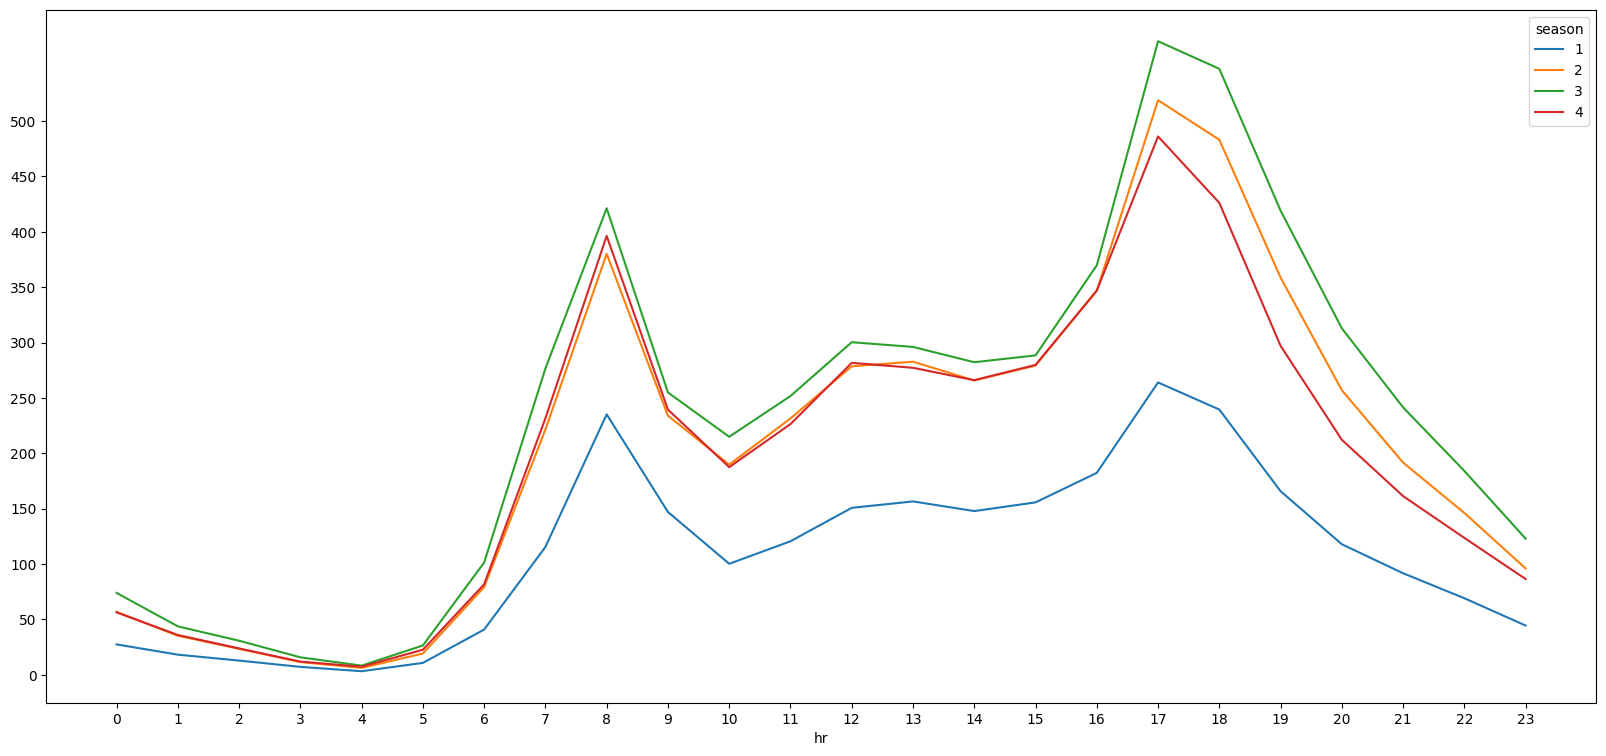

In [9]:
data[data.cnt.notnull()].groupby(["hr", "season"]).cnt.mean().unstack().plot(figsize=(20, 9), xticks=range(0, 24), yticks=range(0, 550, 50))

plt.show()

- We can infer that season 1 (blue line) is winter

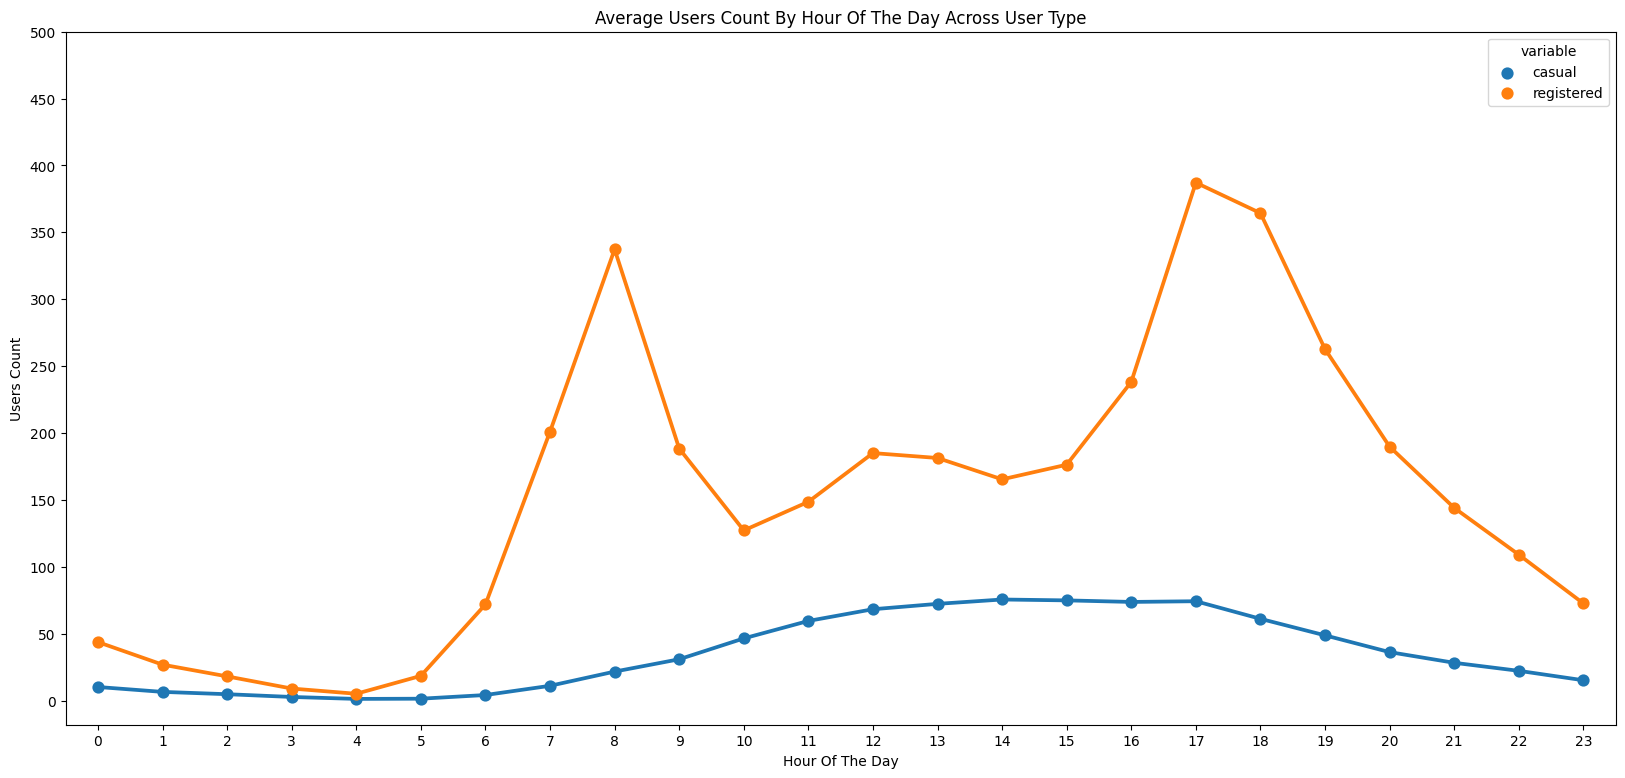

In [10]:
hourTransformed = pd.melt(data[["hr", "casual", "registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hr", "variable"], sort=True)["value"].mean()).reset_index()

plt.figure(figsize=(20, 9))
ax = sns.pointplot(x=hourAggregated["hr"], y=hourAggregated["value"], hue=hourAggregated["variable"],
                   hue_order=["casual", "registered"], join=True)

ax.set(xlabel='Hour Of The Day', ylabel='Users Count',
       title="Average Users Count By Hour Of The Day Across User Type", label='big')

plt.xticks(range(0, 24))
plt.yticks(range(0, 550, 50))

plt.show()

- Despite the hour, registered users seem to always rent more bikes than casual users.

In [11]:
fig = px.bar(data, x='hr', y='cnt', title='Hourly Count', 
             labels={'hr': 'Hour', 'cnt': 'Count'},
             width=800, height=500, color='cnt', 
             color_continuous_scale='viridis') 

fig.update_layout(xaxis=dict(type='category')) 
fig.show()

In [12]:
fig = px.bar(data, x='mnth', y='cnt', title='Hourly Count', 
             labels={'mnth': 'Month', 'cnt': 'Count'},
             width=800, height=500, color='cnt',
             color_continuous_scale='viridis')

fig.update_layout(xaxis=dict(type='category'))
fig.show()

In [13]:
#working day
fig = px.histogram(data, x='workingday', color='workingday',
                   labels={'workingday': 'Working Day'},
                   title='Count Plot of Working Day',
                   width=600, height=400)
fig.show()

In [14]:
# holiday
fig = px.histogram(data, x='holiday', color='holiday',
                   labels={'holiday': 'Holiday'},
                   title='Count Plot of Holiday',
                   width=600, height=400)
fig.show()

In [15]:
# weather
fig = px.histogram(data, x='weathersit', color='weathersit',
                   labels={'weathersit': 'Weather'},
                   title='Count Plot of Weather Situation',
                   width=600, height=400)
fig.show()

In [16]:
data.describe()

season            yr          mnth            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.106918      0.500008      3.438776      6.914405      0.167165   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      4.000000      6.000000      0.000000   
50%        3.000000      1.000000      7.000000     12.000000      0.000000   
75%        3.000000      1.000000     10.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683      0.682721      1.425283      0.496987      0.475775   
std        2.005771      0.465431      0.639357      0.192556      0.171850   
min        0.000000      0.000000      1.000000      0.020000      0.000000   
25%        1.000000      0.000000      1.000000      0.340000      0.333300   
50%        3.000000      1.000000      1.000000      0.500000      0.484800   
75%        5.000000      1.000000      2.000000      0.660000      0.621200   
max        6.000000      1.000000      4.000000      1.000000      1.000000   

                hum     windspeed        casual    registered           cnt  
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000  
mean       0.627229      0.190098     35.676218    153.786869    189.463088  
std        0.192930      0.122340     49.305030    151.357286    181.387599  
min        0.000000      0.000000      0.000000      0.000000      1.000000  
25%        0.480000      0.104500      4.000000     34.000000     40.000000  
50%        0.630000      0.194000     17.000000    115.000000    142.000000  
75%        0.780000      0.253700     48.000000    220.000000    281.000000  
max        1.000000      0.850700    367.000000    886.000000    977.000000

- Temperature, atemp, and humidity as a fraction.
- Temp and atemp probably in F -> Max for Temp and atemp is 1 which doesn't make sense on a C scale

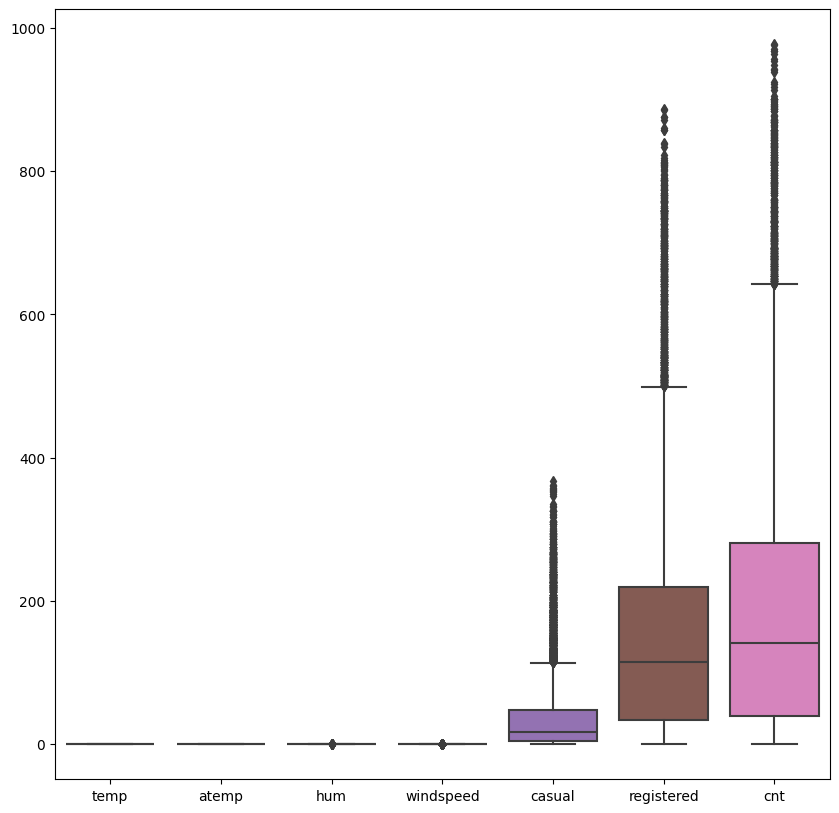

In [17]:
# just to visualize.
sns.boxplot(data=data[['temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']])
fig=plt.gcf()
fig.set_size_inches(10,10)

In [18]:
fig = px.histogram(data, x='temp', title='Variation of temp', nbins=30,
                   labels={'temp': 'Temperature'})
fig.update_layout(width=600, height=400)

fig.show()

In [19]:
fig = px.histogram(data, x='atemp', title='Variation of atemp', nbins=30,
                   labels={'atemp': 'Apparent Temperature'})
fig.update_layout(width=600, height=400)

fig.show()

In [20]:
fig = px.histogram(data, x='windspeed', title='Variation of windspeed', nbins=30,
                   labels={'windspeed': 'Windspeed'})
fig.update_layout(width=600, height=400)

fig.show()

In [21]:
fig = px.histogram(data, x='hum', title='Variation of humidity', nbins=30,
                   labels={'hum': 'Humidity'})
fig.update_layout(width=600, height=400)

fig.show()

In [22]:
fig = px.scatter(data, x='temp', y='cnt', title='Scatter Plot for Temperature and Count',
                 labels={'temp': 'Temperature', 'cnt': 'Count'},
                 color='cnt', color_continuous_scale='Viridis')

fig.show()

In [23]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])

cor_mat = numeric_data.corr()
cor_mat = np.triu(cor_mat)

fig = go.Figure(data=go.Heatmap(z=cor_mat, x=numeric_data.columns, y=numeric_data.columns,
                                colorscale='Viridis', colorbar=dict(title='Correlation')))
fig.update_layout(title='Correlation Matrix', width=800, height=600)

fig.show()

- Temp and atemp are highly correlated.
- Humidity and count are not highly correlated - indicating that when it is humid people do not want to travel on a bike (increased heat/sweat).
- Casual and working day are not highly correlated.
- Count and holiday are not highly correlated.
- Temp/atemp correlates with count.
- Weather and count are not highly correlated. In our previous graphs, we saw that going from 1-4 decreases count which may indicate that going from 1-4 the weather is getting worse (less bike rentals).
- Registered and casual are correlated which indicates that most of the bikes that are rented as registered.

### Data Preprocessing

In [24]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Specify the categorical columns to be encoded
categorical_columns = ['season', 'weathersit']

# Reshape the specified categorical columns to a 2D array before fitting the encoder
categorical_columns_reshaped = data[categorical_columns].values.reshape(-1, len(categorical_columns))

# Perform one-hot encoding on the specified categorical columns
categorical_columns_encoded = pd.DataFrame(encoder.fit_transform(categorical_columns_reshaped),
                                           columns=encoder.get_feature_names_out(categorical_columns))

# Convert the one-hot encoded values to integers because sparse_output=False is still producing float
categorical_columns_encoded = categorical_columns_encoded.astype(int)

# Concatenate the encoded features with the original DataFrame
data = pd.concat([data.drop(categorical_columns, axis=1), categorical_columns_encoded], axis=1)

In [25]:
data.head(5)

yr  mnth  hr  holiday  weekday  workingday  temp   atemp   hum  windspeed  \
0   0     1   0        0        6           0  0.24  0.2879  0.81        0.0   
1   0     1   1        0        6           0  0.22  0.2727  0.80        0.0   
2   0     1   2        0        6           0  0.22  0.2727  0.80        0.0   
3   0     1   3        0        6           0  0.24  0.2879  0.75        0.0   
4   0     1   4        0        6           0  0.24  0.2879  0.75        0.0   

   ...  registered  cnt  season_1  season_2  season_3  season_4  weathersit_1  \
0  ...          13   16         1         0         0         0             1   
1  ...          32   40         1         0         0         0             1   
2  ...          27   32         1         0         0         0             1   
3  ...          10   13         1         0         0         0             1   
4  ...           1    1         1         0         0         0             1   

   weathersit_2  weathersit_3  weathersit_4  
0             0             0             0  
1             0             0             0  
2             0             0             0  
3             0             0             0  
4             0             0             0  

[5 rows x 21 columns]

## Model

In [26]:
X = data.drop(columns=['cnt'])
y = data['cnt']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Define a list of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Machine': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}

# Evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Display results
    print(f"Model: {model_name}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    print("----------------------------")

Model: Linear Regression
Mean Absolute Error (MAE): 0.00
Root Mean Squared Error (RMSE): 0.00
R-squared (R2): 1.00
----------------------------
Model: Decision Tree
Mean Absolute Error (MAE): 2.27
Root Mean Squared Error (RMSE): 5.22
R-squared (R2): 1.00
----------------------------
Model: Random Forest
Mean Absolute Error (MAE): 0.96
Root Mean Squared Error (RMSE): 2.74
R-squared (R2): 1.00
----------------------------
Model: Support Vector Machine
Mean Absolute Error (MAE): 4.77
Root Mean Squared Error (RMSE): 22.95
R-squared (R2): 0.98
----------------------------
Model: XGBoost
Mean Absolute Error (MAE): 1.77
Root Mean Squared Error (RMSE): 3.19
R-squared (R2): 1.00
----------------------------


- MAE is suitable when the error needs to be presented in the same units as the target variable.
- RMSE is sensitive to outliers and penalizes larger errors more heavily.
- R2 is a relative measure of model performance, indicating the proportion of the variance in the target variable that the model explains.

Random Forest produces the best results

### Random Forest - Optuna

In [29]:
def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_float('max_features', 0.01, 1.0)

    # Create RandomForestRegressor with suggested hyperparameters
    rf_reg = RandomForestRegressor	(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Use cross-validation to evaluate the model

    score = -cross_val_score(rf_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    
    # Return the average MAE 
    return score

In [30]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-03-13 13:07:59,575] A new study created in memory with name: no-name-016c2ae5-13aa-4fa6-b546-6176a56061fc


In [31]:
study.optimize(objective, n_trials=50)

[I 2024-03-13 13:08:03,531] Trial 0 finished with value: 25.751219354114063 and parameters: {'n_estimators': 218, 'max_depth': 42, 'min_samples_split': 37, 'min_samples_leaf': 30, 'max_features': 0.16445845403801215}. Best is trial 0 with value: 25.751219354114063.
[I 2024-03-13 13:08:04,763] Trial 1 finished with value: 37.772368383028756 and parameters: {'n_estimators': 120, 'max_depth': 2, 'min_samples_split': 44, 'min_samples_leaf': 31, 'max_features': 0.710991852018085}. Best is trial 0 with value: 25.751219354114063.
[I 2024-03-13 13:08:05,464] Trial 2 finished with value: 22.270655100552297 and parameters: {'n_estimators': 59, 'max_depth': 45, 'min_samples_split': 42, 'min_samples_leaf': 11, 'max_features': 0.19000671753502962}. Best is trial 2 with value: 22.270655100552297.
[I 2024-03-13 13:08:06,417] Trial 3 finished with value: 39.121017040968766 and parameters: {'n_estimators': 132, 'max_depth': 4, 'min_samples_split': 27, 'min_samples_leaf': 22, 'max_features': 0.298316848

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 200, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.7309068686415673}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
best_max_features = best_params['max_features']

In [ ]:
best_model = RandomForestRegressor(n_estimators=best_n_estimators,
                                    max_depth=best_max_depth,
                                    min_samples_split=best_min_samples_split,
                                    min_samples_leaf=best_min_samples_leaf,
                                    max_features=best_max_features,
                                    random_state=42)

In [ ]:
# Fit the model
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=23, max_features=0.7309068686415673,
                      min_samples_leaf=4, min_samples_split=7, n_estimators=200,
                      random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
    
# Display results
print(f"Model: Random Forest")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print("----------------------------")

Model: Random Forest
Mean Absolute Error (MAE): 1.15
Root Mean Squared Error (RMSE): 3.56
R-squared (R2): 1.00
----------------------------


Random Forest without any hyperparameter tuning produces best results. We will use that model over Optuna for our Streamlit application.